In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [12]:
#load dataset
df = pd.read_csv('../data/data.csv')

## Feature Engineering

### Create Aggregate Features

In [13]:
# Group by CustomerId to create aggregate features
customer_agg = df.groupby('CustomerId').agg(
    total_transaction_amount=('Amount', 'sum'),
    avg_transaction_amount=('Amount', 'mean'),
    transaction_count=('TransactionId', 'count'),
    std_transaction_amount=('Amount', 'std')
).reset_index()

# Fill NaN values for std_transaction_amount (because customers with 1 transaction will have NaN std)
customer_agg['std_transaction_amount'] = customer_agg['std_transaction_amount'].fillna(0)

# View the aggregated customer-level features
customer_agg.head()

,CustomerId,total_transaction_amount,avg_transaction_amount,transaction_count,std_transaction_amount
0,CustomerId_1,-10000.0,-10000.000000,1,0.000000
1,CustomerId_10,-10000.0,-10000.000000,1,0.000000
2,CustomerId_1001,20000.0,4000.000000,5,6558.963333
3,CustomerId_1002,4225.0,384.090909,11,560.498966
4,CustomerId_1003,20000.0,3333.333333,6,6030.478146


### Extract Date-Time Features

In [14]:
# Convert TransactionStartTime to datetime 
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Extract hour, day, month, and year
df['transaction_hour'] = df['TransactionStartTime'].dt.hour
df['transaction_day'] = df['TransactionStartTime'].dt.day
df['transaction_month'] = df['TransactionStartTime'].dt.month
df['transaction_year'] = df['TransactionStartTime'].dt.year

# View the new extracted features
df[['transaction_hour', 'transaction_day', 'transaction_month', 'transaction_year']].head()

,transaction_hour,transaction_day,transaction_month,transaction_year
0,2,15,11,2018
1,2,15,11,2018
2,2,15,11,2018
3,3,15,11,2018
4,3,15,11,2018


### Encode Categorical Variables

In [15]:
#You can use Label Encoding for ordinal categorical variables and One-Hot Encoding for nominal categorical variables.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Label Encoding example for ProductCategory (if it's ordinal)
label_encoder = LabelEncoder()
df['product_category_encoded'] = label_encoder.fit_transform(df['ProductCategory'])

# One-Hot Encoding for non-ordinal categorical variables like CurrencyCode, CountryCode
df_encoded = pd.get_dummies(df, columns=['CurrencyCode', 'CountryCode'], drop_first=True)

# View encoded features
df_encoded.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,transaction_hour,transaction_day,transaction_month,transaction_year,product_category_encoded
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,2,15,11,2018,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0,2,15,11,2018,2
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0,2,15,11,2018,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0,3,15,11,2018,8
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0,3,15,11,2018,2


### Normalize Numerical Features

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Select numerical columns to normalize
numerical_columns = ['Amount', 'Value', 'transaction_hour']

# Apply normalization
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# View the normalized data
df[numerical_columns].head()

,Amount,Value,transaction_hour
0,0.092004,0.000101,0.086957
1,0.091910,0.000002,0.086957
2,0.091958,0.000050,0.086957
3,0.093750,0.002206,0.130435
4,0.091853,0.000065,0.130435


### Standardize Numerical Features

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Apply standardization
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# View the standardized data
df[numerical_columns].head()

,Amount,Value,transaction_hour
0,-0.046371,-0.072291,-2.155530
1,-0.054643,-0.080251,-2.155530
2,-0.050426,-0.076352,-2.155530
3,0.107717,0.096648,-1.949214
4,-0.059704,-0.075183,-1.949214


### RFMS Features

In [18]:
# Ensure 'TransactionStartTime' is in datetime format
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Define Recency: Days since the last transaction for each customer
current_date = df['TransactionStartTime'].max()

df['Recency'] = (current_date - df.groupby('CustomerId')['TransactionStartTime'].transform('max')).dt.days

# Define Frequency: Number of transactions per customer
df['Frequency'] = df.groupby('CustomerId')['TransactionId'].transform('count')

# Define Monetary: Total amount spent by each customer
df['Monetary'] = df.groupby('CustomerId')['Amount'].transform('sum')

# Define Seasonality: Standard deviation of transactions by month (as a proxy for seasonality)
df['TransactionMonth'] = df['TransactionStartTime'].dt.month
seasonality = df.groupby(['CustomerId', 'TransactionMonth']).size().groupby('CustomerId').std()
df = df.merge(seasonality.rename('Seasonality'), on='CustomerId', how='left')

# Aggregate RFMS features at the customer level
rfms_features = df[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Seasonality']].drop_duplicates()
rfms_features.head()

,CustomerId,Recency,Frequency,Monetary,Seasonality
0,CustomerId_4406,0,119,-5.591789,17.632829
2,CustomerId_4683,81,2,-0.100852,NaN
3,CustomerId_988,5,38,-0.215326,6.137318
5,CustomerId_1432,90,1,-0.038261,NaN
6,CustomerId_2858,5,29,-0.822486,6.849574


### Visualize RFMS and Classify Users

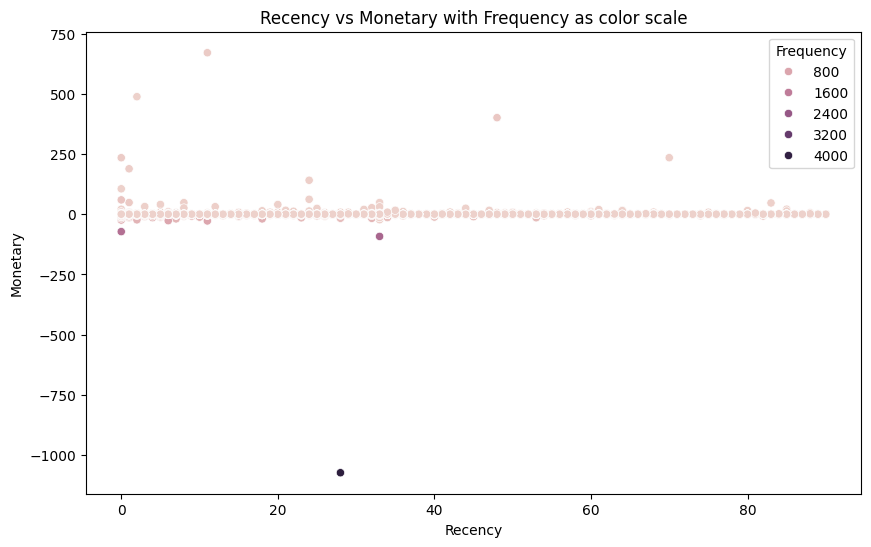

,CustomerId,Recency,Monetary,DefaultProxy
0,CustomerId_4406,0,-5.591789,0
2,CustomerId_4683,81,-0.100852,1
3,CustomerId_988,5,-0.215326,0
5,CustomerId_1432,90,-0.038261,1
6,CustomerId_2858,5,-0.822486,0


In [19]:
# Scatter plot of Recency vs. Monetary
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Frequency', data=rfms_features)
plt.title('Recency vs Monetary with Frequency as color scale')
plt.show()

# Based on the visualization, define a threshold to classify users (example: Recency > 30, Monetary < 500)
# Modify this logic based on your data and visualization
rfms_features['DefaultProxy'] = np.where((rfms_features['Recency'] > 30) & (rfms_features['Monetary'] < 500), 1, 0)  # 1 = bad, 0 = good

# View classification result
rfms_features[['CustomerId', 'Recency', 'Monetary', 'DefaultProxy']].head()

In [21]:
from optbinning import BinningProcess, OptimalBinning

# Select the features for binning (Recency, Frequency, Monetary, Seasonality)
features_for_binning = ['Recency', 'Frequency', 'Monetary', 'Seasonality']

# Initialize the binning process
binning_process = BinningProcess(variable_names=features_for_binning)

# Fit the binning process using the DefaultProxy as the target variable
X = rfms_features[features_for_binning]
y = rfms_features['DefaultProxy']

binning_process.fit(X, y)

# Apply binning to transform the features into WoE-binned versions
X_binned = binning_process.transform(X)

# View WoE-binned features
X_binned_df = pd.DataFrame(X_binned, columns=features_for_binning)
X_binned_df.head()

c:\Users\lenovo\Documents\10acadmy\Credit_Scoring_Model\.venv\lib\site-packages\optbinning\binning\transformations.py:38: RuntimeWarning: invalid value encountered in log
  return np.log((1. / event_rate - 1) * n_event / n_nonevent)


,Recency,Frequency,Monetary,Seasonality
0,-2.220446e-16,2.038506,1.530822,1.554033
2,-2.220446e-16,-1.015321,-0.704560,0.000000
3,-2.220446e-16,1.779400,-0.045199,1.423820
5,-2.220446e-16,-1.015321,-0.704560,0.000000
6,-2.220446e-16,1.130135,1.266817,1.423820


In [34]:
# Calculate WoE for Recency feature
optimal_binning_recency = OptimalBinning(name="Recency", dtype="numerical", solver="cp")
optimal_binning_recency.fit(rfms_features['Recency'], rfms_features['DefaultProxy'])

# Get binning table to analyze WoE
binning_table_recency = optimal_binning_recency.binning_table.build()
print(binning_table_recency)

# # Plot WoE for Recency
# binning_table_recency.plot(metric="woe")
# plt.title('Weight of Evidence (WoE) for Recency')
# plt.show()
# plt.figure(figsize=(10, 6))
# plt.bar(binning_table_recency['Bin'], binning_table_recency['IV'])
# plt.xlabel('Bin')
# plt.ylabel('Weight of Evidence (WoE)')
# plt.title('Weight of Evidence (WoE) for Recency')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.grid(True)
# plt.show()

                Bin  Count  Count (%)  Non-event  Event  Event rate  WoE   IV  \
0       (-inf, inf)   3742        1.0       2084   1658    0.443079 -0.0  0.0   
1           Special      0        0.0          0      0    0.000000  0.0  0.0   
2           Missing      0        0.0          0      0    0.000000  0.0  0.0   
Totals                3742        1.0       2084   1658    0.443079       0.0   

         JS  
0       0.0  
1       0.0  
2       0.0  
Totals  0.0  


In [35]:
def calculate_woe(df, feature, target):
  """
  Calculates WOE for a feature in a DataFrame.

  Args:
      df (pandas.DataFrame): The DataFrame containing features and target.
      feature (str): The name of the feature to calculate WOE for.
      target (str): The name of the target variable.

  Returns:
      pandas.DataFrame: A DataFrame containing WOE for each category of the feature.
  """
  crosstab = pd.crosstab(df[feature], df[target], normalize='columns')
  crosstab['woe'] = lambda x: log(x[1] / x[0])
  return crosstab

woe_recency = calculate_woe(rfms_features, 'Recency', 'DefaultProxy')
# print(woe_recency)

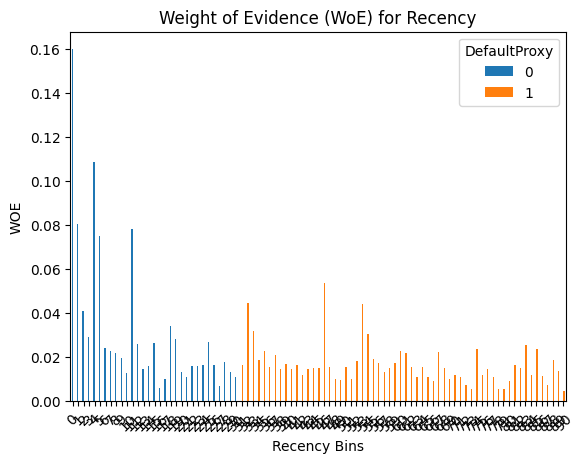

In [31]:
# Plotting WOE using matplotlib
import matplotlib.pyplot as plt

woe_recency.plot(kind='bar')  # Plot WOE as a bar chart
plt.title('Weight of Evidence (WoE) for Recency')
plt.xlabel('Recency Bins')
plt.ylabel('WOE')
plt.xticks(rotation=45)
plt.show()

### Split the Data

In [25]:
from sklearn.model_selection import train_test_split

# Features (RFMS + WoE bins)
X = X_binned_df  # Features after WoE binning
y = rfms_features['DefaultProxy']  # Target variable (0 = good, 1 = bad)

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shape of the train/test split
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2993, 4), Test shape: (749, 4)


### Choose Models

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize models
#LogisticRegression
log_reg = LogisticRegression(random_state=42)

#RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

### Train the Models

In [27]:
# Train Logistic Regression
log_reg.fit(X_train, y_train)

# Train Random Forest
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Hyperparameter Tuning

In [28]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for Random Forest
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random search with 5-fold cross-validation
random_search = RandomizedSearchCV(rf_clf, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters for Random Forest:", random_search.best_params_)

# Train the Random Forest with the best parameters
best_rf_clf = random_search.best_estimator_

Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}


### Model Evaluation

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    return accuracy, precision, recall, f1, roc_auc

# Evaluate Logistic Regression
log_reg_metrics = evaluate_model(log_reg, X_test, y_test)
print(f"Logistic Regression Metrics: \nAccuracy={log_reg_metrics[0]}, \nPrecision={log_reg_metrics[1]}, \nRecall={log_reg_metrics[2]}, \nF1={log_reg_metrics[3]}, \nROC-AUC={log_reg_metrics[4]}\n")

# Evaluate Random Forest
rf_metrics = evaluate_model(best_rf_clf, X_test, y_test)
print(f"Random Forest Metrics: \nAccuracy={rf_metrics[0]}, \nPrecision={rf_metrics[1]}, \nRecall={rf_metrics[2]}, \nF1={rf_metrics[3]}, \nROC-AUC={rf_metrics[4]}")

Logistic Regression Metrics: 
Accuracy=0.6675567423230975, 
Precision=0.5976470588235294, 
Recall=0.7650602409638554, 
F1=0.6710700132100397, 
ROC-AUC=0.7348675276646153

Random Forest Metrics: 
Accuracy=0.671562082777036, 
Precision=0.5934782608695652, 
Recall=0.822289156626506, 
F1=0.6893939393939394, 
ROC-AUC=0.7407977232671694
